# Autoencoders

The aim of an autoencoder is to learn a representation (encoding) for a set of data, typically for dimensionality reduction, by training the network to ignore signal “noise”. Along with the reduction side, a reconstructing side is learnt, where the autoencoder tries to generate from the reduced encoding a representation as close as possible to its original input, hence its name.

# 1)-Import key modules

In [1]:
from keras.layers import Input, Dense, Flatten, Reshape
from keras.models import Model, Sequential

from keras.datasets import mnist
from keras.callbacks import Callback
import numpy as np
import wandb
from wandb.keras import WandbCallback
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
run = wandb.init()
config = run.config

wandb: ERROR To use wandb on Windows, you need to run the command "wandb run python <your_train_script>.py"


In [3]:
config.encoding_dim = 32
config.epochs = 10

# 2) Loading data

In [4]:
(x_train, _), (x_test, _) = mnist.load_data()

In [5]:
# no y label as we are using X to represent x as outpur
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


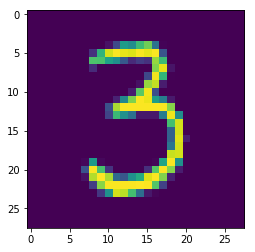

In [6]:
# lets see what the images look like

image = x_train[50, :].reshape((28, 28)) # checking a random row i.e 50 for image

plt.imshow(image)
plt.show()

### Normalize data

In [7]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# 3) Model

### a.Building model

In [8]:
model = Sequential()
model.add(Flatten(input_shape=(28,28)))
model.add(Dense(config.encoding_dim, activation='relu'))
model.add(Dense(28*28, activation='sigmoid'))
model.add(Reshape((28,28)))
model.compile(optimizer='adam', loss='mse') # as we working on performance so mse is better than accuracy

Instructions for updating:
Colocations handled automatically by placer.


In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                25120     
_________________________________________________________________
dense_2 (Dense)              (None, 784)               25872     
_________________________________________________________________
reshape_1 (Reshape)          (None, 28, 28)            0         
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


### b. For visualization

In [10]:
class Images(Callback):
      def on_epoch_end(self, epoch, logs):
            indices = np.random.randint(self.validation_data[0].shape[0], size=8)
            test_data = self.validation_data[0][indices]
            pred_data = self.model.predict(test_data)
            run.history.row.update({
                  "examples": [
                        wandb.Image(np.hstack([data, pred_data[i]]), caption=str(i))
                        for i, data in enumerate(test_data)]
            })

### c.Fitting model

In [11]:
history=model.fit(x_train, x_train,
                epochs=config.epochs,
                validation_data=(x_test, x_test))

Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 2s 31us/step - loss: 0.0321 - val_loss: 0.0161
Epoch 2/10
60000/60000 [==============================] - 2s 30us/step - loss: 0.0134 - val_loss: 0.0113
Epoch 3/10
60000/60000 [==============================] - 2s 29us/step - loss: 0.0112 - val_loss: 0.0104
Epoch 4/10
60000/60000 [==============================] - 2s 30us/step - loss: 0.0107 - val_loss: 0.0102
Epoch 5/10
60000/60000 [==============================] - 2s 29us/step - loss: 0.0105 - val_loss: 0.0101
Epoch 6/10
60000/60000 [==============================] - 2s 29us/step - loss: 0.0104 - val_loss: 0.0101
Epoch 7/10
60000/60000 [==============================] - 2s 30us/step - loss: 0.0103 - val_loss: 0.0100
Epoch 8/10
60000/60000 [==============================] - 2s 29us/step - loss: 0.0103 - val_loss: 0.0099
Epoch 9/10
60000/60000 [==============================] - 2s 2

In [12]:
model.save('auto.h5')

# 4)- Debugging

In [13]:
def add_noise(x_train, x_test):
    # Function to add some random noise
    noise_factor = 1.0
    x_train_noisy = x_train + np.random.normal(loc=0.0, scale=noise_factor, size=x_train.shape) 
    x_test_noisy = x_test + np.random.normal(loc=0.0, scale=noise_factor, size=x_test.shape) 
    
    x_train_noisy = np.clip(x_train_noisy, 0., 1.)
    x_test_noisy = np.clip(x_test_noisy, 0., 1.)
    return x_train_noisy, x_test_noisy

In [14]:
def log_images(epoch, logs):
    # Function to show the before and after images at each step
    indices = np.random.randint(x_test_noisy.shape[0], size=8)
    test_data = x_test_noisy[indices]
    pred_data = np.clip(model.predict(test_data), 0, 1)
    wandb.log({
            "examples": [
                wandb.Image(np.hstack([data, pred_data[i]]), caption=str(i))
                for i, data in enumerate(test_data)]
        }, commit=False)

In [15]:
(x_train, _), (x_test, _) = mnist.load_data()
(x_train_noisy, x_test_noisy) = add_noise(x_train, x_test)
img_width = x_train.shape[1]
img_height = x_train.shape[2]

In [16]:
x_train = x_train / 255.
x_test = x_test / 255.

In [17]:
# create model
model = Sequential()
model.add(Flatten(input_shape=(img_width, img_height)))
model.add(Dense(config.encoding_dim, activation="relu"))
model.add(Dense(img_width*img_height, activation="sigmoid"))
model.add(Reshape((img_width, img_height)))
model.compile(loss='mse', optimizer='adam',
              metrics=['mse'])

In [18]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                25120     
_________________________________________________________________
dense_4 (Dense)              (None, 784)               25872     
_________________________________________________________________
reshape_2 (Reshape)          (None, 28, 28)            0         
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


In [19]:
history=model.fit(x_train_noisy, x_train, epochs=30, validation_data=(x_test_noisy, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 2s 35us/step - loss: 0.0402 - mean_squared_error: 0.0402 - val_loss: 0.0258 - val_mean_squared_error: 0.0258
Epoch 2/30
60000/60000 [==============================] - 2s 33us/step - loss: 0.0239 - mean_squared_error: 0.0239 - val_loss: 0.0220 - val_mean_squared_error: 0.0220
Epoch 3/30
60000/60000 [==============================] - 2s 32us/step - loss: 0.0221 - mean_squared_error: 0.0221 - val_loss: 0.0213 - val_mean_squared_error: 0.0213
Epoch 4/30
60000/60000 [==============================] - 2s 33us/step - loss: 0.0217 - mean_squared_error: 0.0217 - val_loss: 0.0213 - val_mean_squared_error: 0.0213
Epoch 5/30
60000/60000 [==============================] - 2s 32us/step - loss: 0.0215 - mean_squared_error: 0.0215 - val_loss: 0.0210 - val_mean_squared_error: 0.0210
Epoch 6/30
60000/60000 [==============================] - 2s 33us/step - loss: 0.0214 - mean_squared_error: 0.0214 

Both lower value of loss from real image to encoded output show that encoded image is clear, less noisey